In [6]:
%matplotlib widget
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../src')
sys.path.append('../data')

from pathlib import Path

datap = Path('../data')
%reload_ext autoreload
%aimport load
%aimport utils
%aimport spectr

#from definitions import *
from load import read_rad_prof, read_pol_prof, load_binary,extract_to_binary

from scipy.signal import welch, csd, correlate, coherence
from scipy.signal import correlation_lags # Note: requires a recent version of SciPy

from utils import dt, R, NR, Z, dZ, normalized, find_nearest, fluct_level
from spectr import get_tau_corr, Corr_profile, nperseg, plot_spec, dx_pol, Theta, X_theta, get_kspec, adjacent_Corr

from numpy import pi

In [7]:
Dat = load_binary('poloidal')

In [8]:
iPhi = np.arange(0,64, step=2, dtype=int)
Phi = Dat[iPhi]
iIsat = np.arange(1,64, step=2, dtype=int)
Isat = Dat[iIsat]

In [9]:
Isat.shape

(32, 2, 1024000)

In [11]:
%autoreload 1
from utils import plot_pdf, pdf_stat

In [12]:
bin_centers, Hist, Skew, Kurtosis = pdf_stat(Dat, shot='poloidal')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
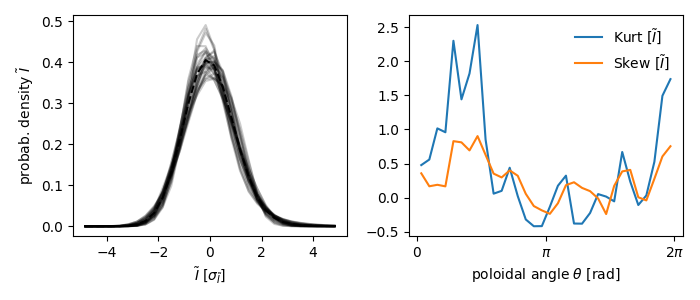

In [13]:
%autoreload 1

plot_pdf(bin_centers, Hist, Skew, Kurtosis, shot='poloidal')
plt.tight_layout()

Text(0.5, 1.0, 'fluctuation level')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
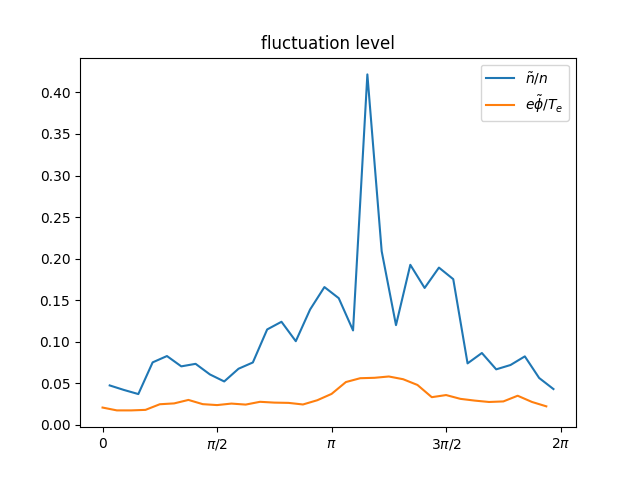

In [22]:
%autoreload 1
dn, dphi = fluct_level(Dat, itor=0)

fig, ax = plt.subplots()

ax.plot(Theta[iIsat], dn, label=r'$\tilde{n} / n$')
ax.plot(Theta[iPhi], dphi, label=r'$e  \tilde{\phi} / T_e$')

ax.set_xticks([0, np.pi/2, pi, 3*pi/2, 2*pi])
ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']);
ax.legend()
ax.set_title('fluctuation level')

In [14]:
CrossCorr_phi = adjacent_Corr(Dat, quantity='phi')
CrossCorr_I   = adjacent_Corr(Dat, quantity='I')

In [11]:
CrossCorr_I_E = adjacent_Corr(Dat, quantity='E_I')

In [12]:
CrossCorr_phi_I = adjacent_Corr(Dat, quantity='phi_I')

In [13]:
CrossCorr_phi = adjacent_Corr(Dat, quantity='phi', itor=1)
CrossCorr_I   = adjacent_Corr(Dat, quantity='I', itor=1)

KeyboardInterrupt: 

In [ ]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(9,3))
_ax1 = ax1.twinx()
_ax1.set_ylabel('max. correlation')
_ax1.yaxis.label.set_color('blue')

ax1.yaxis.label.set_color('red')

for CCorr, ls, lab in zip([CrossCorr_phi, CrossCorr_I], ['-', '--'], [r'$\tilde{\phi}$', r'$\tilde{I}$']):

    tau_c = (CCorr[:,1] - CCorr[:,0] ) / 2

    ax1.plot(X_theta[iPhi] * 1e3,  tau_c * 1e6, ls=ls, color='red', label=lab)
    ax1.set_xlabel('poloidal pos. [mm]')
    ax1.set_ylabel(r'correlation time $\tau_c$ [µs]')
    ax1.set_title(r'$\tau_c$ between adjacent signals')
    
    
    _ax1.plot(X_theta[iPhi] * 1e3, CCorr[:,-1], color='blue', ls=ls)

    tau_max = CCorr[:,2]
    max_corr = CCorr[:,3]
    vfluct = 2 * dx_pol / tau_max
    ax2.plot(X_theta[iPhi] * 1e3, vfluct * 1e-3, ls=ls)
    ax2.set_title(r'velocity from correl. delay $C_{\tilde{\phi}_1 \tilde{\phi}_2}$')
    ax2.set_ylabel(r'$v_\theta$ [km/s]')
    ax2.set_xlabel('poloidal pos. [mm]')
ax1.legend()

CCorr = CrossCorr_phi_I
max_corr = CCorr[:,3]
tau_c = (CCorr[:,1] - CCorr[:,0] ) / 2
ax3.plot(X_theta[iPhi] * 1e3,  tau_c * 1e6, color='red', label=lab)
_ax3 = ax3.twinx()
_ax3.plot(X_theta[iPhi] * 1e3,  max_corr, ls=ls, color='blue', label=lab)
ax3.set_title(r'CCorrelation $\tilde{\phi} \tilde{I}$')
_ax3.set_ylabel('max. correlation')
_ax3.yaxis.label.set_color('blue')
ax3.set_ylabel(r'correlation time $\tau_c$ [µs]')
ax3.yaxis.label.set_color('red')

plt.tight_layout()

### Correlate current and electric field

In [ ]:
def adjacent_Corr(Dat, quantity='phi', threshold=np.exp(-1), itor=0):
    """
    Returns for each radial position the left and right 1/e time delay,
    the time corresponding to the correlation maximum and the correlation value at that maximum.
    """
    
    iPhi = np.arange(0,64, step=2, dtype=int)
    Phi = Dat[iPhi]
    iIsat = np.arange(1,64, step=2, dtype=int)
    Isat = Dat[iIsat]
    
    Q = Phi if quantity=='phi' else Isat
    iQ = iPhi if quantity=='phi' else iIsat
        
    Corr = np.zeros((Q.shape[0],4))
    
    for i in range(Q.shape[0]):
        
        dat1 = normalized(Q[i,itor])
        
        if i==Q.shape[0]-1:
            i2 = 0
        else:
            i2 = i+1
            
        dat2 = normalized(Q[i2, itor])

        corr = correlate(dat1, dat2, method='fft') / dat1.size
        lags = correlation_lags(dat1.size, dat2.size)
        tau = lags * dt

        Corr[i,:2] = get_tau_corr(tau, corr, threshold)
        Corr[i, 2] = tau[np.argmax(corr)]
        Corr[i, 3] = np.max(corr)

    return Corr

### Fourier analysis, $k_\theta$-space

In [78]:
Phi.shape

(32, 2, 1024000)

In [162]:
kth, kSpec_phi = get_kspec(Dat, quantity='phi')
kth, kSpec_Isat = get_kspec(Dat, quantity='I')

8632.8125
7166.666666666668
-15640.625000000002
34531.25
-inf
34531.25
-15640.625000000002
7166.666666666668


<ipython-input-163-e4d1b21b07e7>:10: RuntimeWarning: divide by zero encountered in double_scalars
  Doppler_vel = frq[np.argmax(spec)] * 2 * np.pi / kth[itheta]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
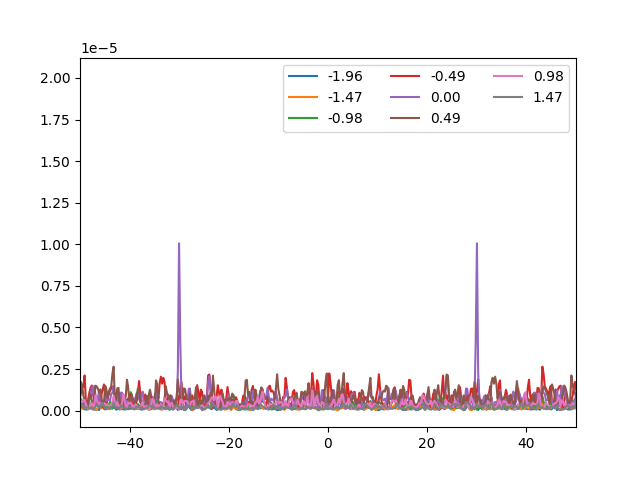

In [163]:
fig, ax = plt.subplots()

for itheta in np.arange(start=0, stop = Kspec.shape[-1], step=4):
    frq, spec = welch(Kspec[:,itheta], fs=1/dt, nperseg=nperseg, return_onesided=False)
    frq = fftshift(frq)
    spec = fftshift(spec)

    ax.plot(frq * 1e-3, spec, label='{:.2f}'.format(kth[itheta] * 1e-2))
    
    Doppler_vel = frq[np.argmax(spec)] * 2 * np.pi / kth[itheta]
    print(Doppler_vel)
ax.set_xlim(-50, 50)
ax.legend(ncol=3)

-0.08148733086305042
-0.08148733086305042


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
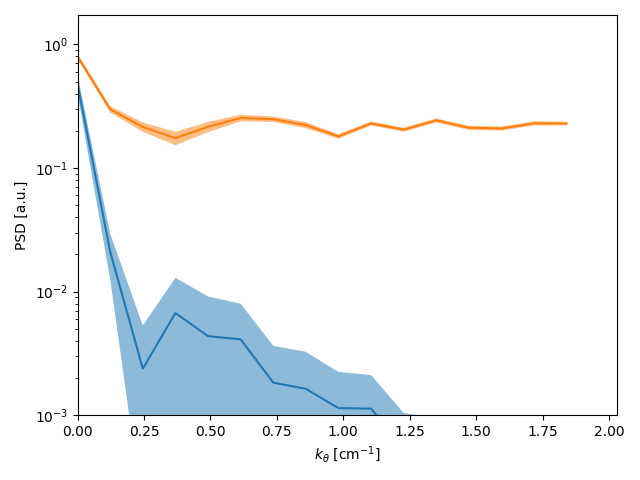

In [170]:
fig, ax = plt.subplots()

for Kspec in [kSpec_phi, kSpec_Isat]:
    Stheta = np.abs(Kspec)**2
    Stheta = Stheta / Stheta.max()
    Stheta_m = np.mean(Stheta, axis=0)
    Stheta_std = np.std(Stheta, axis=0)
    ax.plot(kth * 1e-2, Stheta_m)

    i_corrlen,_= find_nearest(Stheta_m, Stheta_m.max() / np.exp(1))
    corrlen = 1 / kth[i_corrlen]
    print(corrlen)
    ax.axvline(kth[i_corrlen] * 1e-2)

    y1 = Stheta_m-Stheta_std
    y2 = Stheta_m+Stheta_std
    y1[y1<=0] = Stheta_m.min()
    ax.fill_between(kth * 1e-2, y1=y1, y2=y2, alpha=0.5)
ax.set_xlim(left=0)
ax.set_xlabel(r'$k_\theta$ [cm$^{-1}$]')
ax.set_ylabel('PSD [a.u.]')
ax.set_yscale('log')
ax.set_ylim(bottom=1e-3)
plt.tight_layout()